# Análisis de datos y relaciones entre variables.

##Activación para Colab

In [0]:
#LMG: Variable para controlar si estamos en Colab o no y aplicar a las celdas:
inColab = False

In [0]:
#LMG: Para Google CoLab tener el repo de Drive:
if inColab:
  from google.colab import drive
  drive.mount('/content/drive')

##Carga de librerías y preparación de datos

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
import seaborn as sns 
from scipy.stats import norm 

In [129]:
#LMG: Para CoLab en sample_data:
if inColab:
  data_consumo = pd.read_csv("/content/drive/My Drive/TFM/data/data_total.csv")
else:
  data_consumo = pd.read_csv("data_total.csv")

  
data_consumo = data_consumo.loc[:, ~data_consumo.columns.str.contains('^Unnamed')]  
data_consumo.head()

,fecha,PVPC_DEF,PVPC_2_PED_NOC,PVPC_ELEC_NOC,date_timestamp,Demanda,Eolica,Nuclear,Solar,Solar_Fotovoltaica,Solar_Termica,Termica_Renovable,Prevista,Programada,date_day,Brent_price,Holiday,Precio de Regulación Secundaria subir,Precio de Regulación Secundaria bajar,Precio mercado SPOT Diario_x,Demanda real,Generación prevista Solar,Saldo total interconexiones programa p48,Generación programada P48 Exportación Portugal,Generación programada P48 Exportación Francia,Generación programada P48 Importación Portugal,Generación programada P48 Importación Francia,Precio SPOT PT,Precio SPOT FR
0,2015-10-01 00:00:00+02:00,117.77,69.49,71.88,1.443650e+09,24984.666667,1003.666667,6012.833333,402.166667,33.0,368.500000,580.166667,24691.833333,24517.0,2015-10-01,47.48,0.0,61.18,NaN,56.65,25305.0,267.6,182.4,-606.6,NaN,NaN,1200.0,56.65,38.56
1,2015-10-01 01:00:00+02:00,117.09,68.21,65.57,1.443654e+09,23550.833333,899.000000,6013.166667,174.833333,33.0,141.333333,584.166667,23440.000000,23169.0,2015-10-01,47.48,0.0,59.59,NaN,53.50,23959.0,195.7,-269.5,-1112.5,NaN,NaN,1200.0,53.50,31.27
2,2015-10-01 02:00:00+02:00,114.59,65.34,62.53,1.443658e+09,22648.166667,927.500000,6013.500000,103.833333,33.0,70.666667,585.833333,22521.166667,22437.0,2015-10-01,47.48,0.0,56.27,49.13,49.69,22873.0,202.1,94.0,-951.0,NaN,NaN,1200.0,49.69,30.66
3,2015-10-01 03:00:00+02:00,116.60,66.53,63.40,1.443661e+09,22203.833333,935.666667,6013.000000,102.000000,33.0,69.000000,588.500000,22335.333333,22281.0,2015-10-01,47.48,0.0,45.99,45.50,49.10,22550.0,61.3,319.7,-846.3,NaN,NaN,1200.0,49.10,29.14
4,2015-10-01 04:00:00+02:00,122.07,71.03,67.37,1.443665e+09,21987.833333,900.833333,6014.166667,101.666667,33.0,68.166667,589.000000,22177.833333,21910.0,2015-10-01,47.48,0.0,52.28,49.13,51.25,22017.0,45.1,405.5,-760.5,NaN,NaN,1200.0,51.25,29.40


Veamos ahora con tipos de variables nos econtramos: 
* **PVPC_DEF**: tarifa pvpc normal (la que hay que predecir)
* **PVPC_2_PED_NOC**: tarifa pvpc noturna
* **PVPC_ELEC_NOC**: tarifa pvpc electrica


* **Demanda**: demanda
* **Demanda real**: Demanda real
* **Prevista**: Demanda prevista	
* **Programada**: Demanda programada


* **Eolica**: demanda de eolica a hora
* **Nuclear**: demanda de Nuclear a hora
* **Solar**: demanda de Solar a hora	
* **Solar_Fotovoltaica**: demanda de Solar_Fotovoltaica a hora
* **Solar_Termica**	: demanda de Solar_Termica a hora
* **Generación prevista Solar**: generación prevista a día +1 solar
* **Termica_Renovable**: demanda de Termica_Renovable a hora


* **Holiday**: % festividad (0 laboral, 0,75 sabado, 1domingo)


* **Brent_price**: Precio del crudo de brent
* **Precio mercado SPOT Diario**: precio mercado España energia
* **Precio mercado SPOT Diario PT**: precio mercado Portugal energia
* **Precio mercado SPOT Diario FR**: precio mercado Francia energia
* **Precio de Regulación Secundaria subir**: indicador si subirá precio (futuro)
* **Precio de Regulación Secundaria bajar**


* **Saldo total interconexiones programa p48**: saldo total importación - exportación
* **Generación programada P48 Exportación Portugal**: saldo exportación portugal
* **Generación programada P48 Exportación Francia**: saldo exportación francia
* **Generación programada P48 Importación Portugal**: saldo importación portugal
* **Generación programada P48 Importación Francia**: saldo importación francia



In [130]:
print(data_consumo.columns)

Index(['fecha', 'PVPC_DEF', 'PVPC_2_PED_NOC', 'PVPC_ELEC_NOC',
       'date_timestamp', 'Demanda', 'Eolica', 'Nuclear', 'Solar',
       'Solar_Fotovoltaica', 'Solar_Termica', 'Termica_Renovable', 'Prevista',
       'Programada', 'date_day', 'Brent_price', 'Holiday',
       'Precio de Regulación Secundaria subir',
       'Precio de Regulación Secundaria bajar', 'Precio mercado SPOT Diario_x',
       'Demanda real', 'Generación prevista Solar',
       'Saldo total interconexiones programa p48',
       'Generación programada P48 Exportación Portugal',
       'Generación programada P48 Exportación Francia',
       'Generación programada P48 Importación Portugal',
       'Generación programada P48 Importación Francia', 'Precio SPOT PT',
       'Precio SPOT FR'],
      dtype='object')


## Estudio de las correlaciones

Ver la tabla de correlaciones es una muy buena forma de hacer una rápida prospección de las relaciones de los datos.

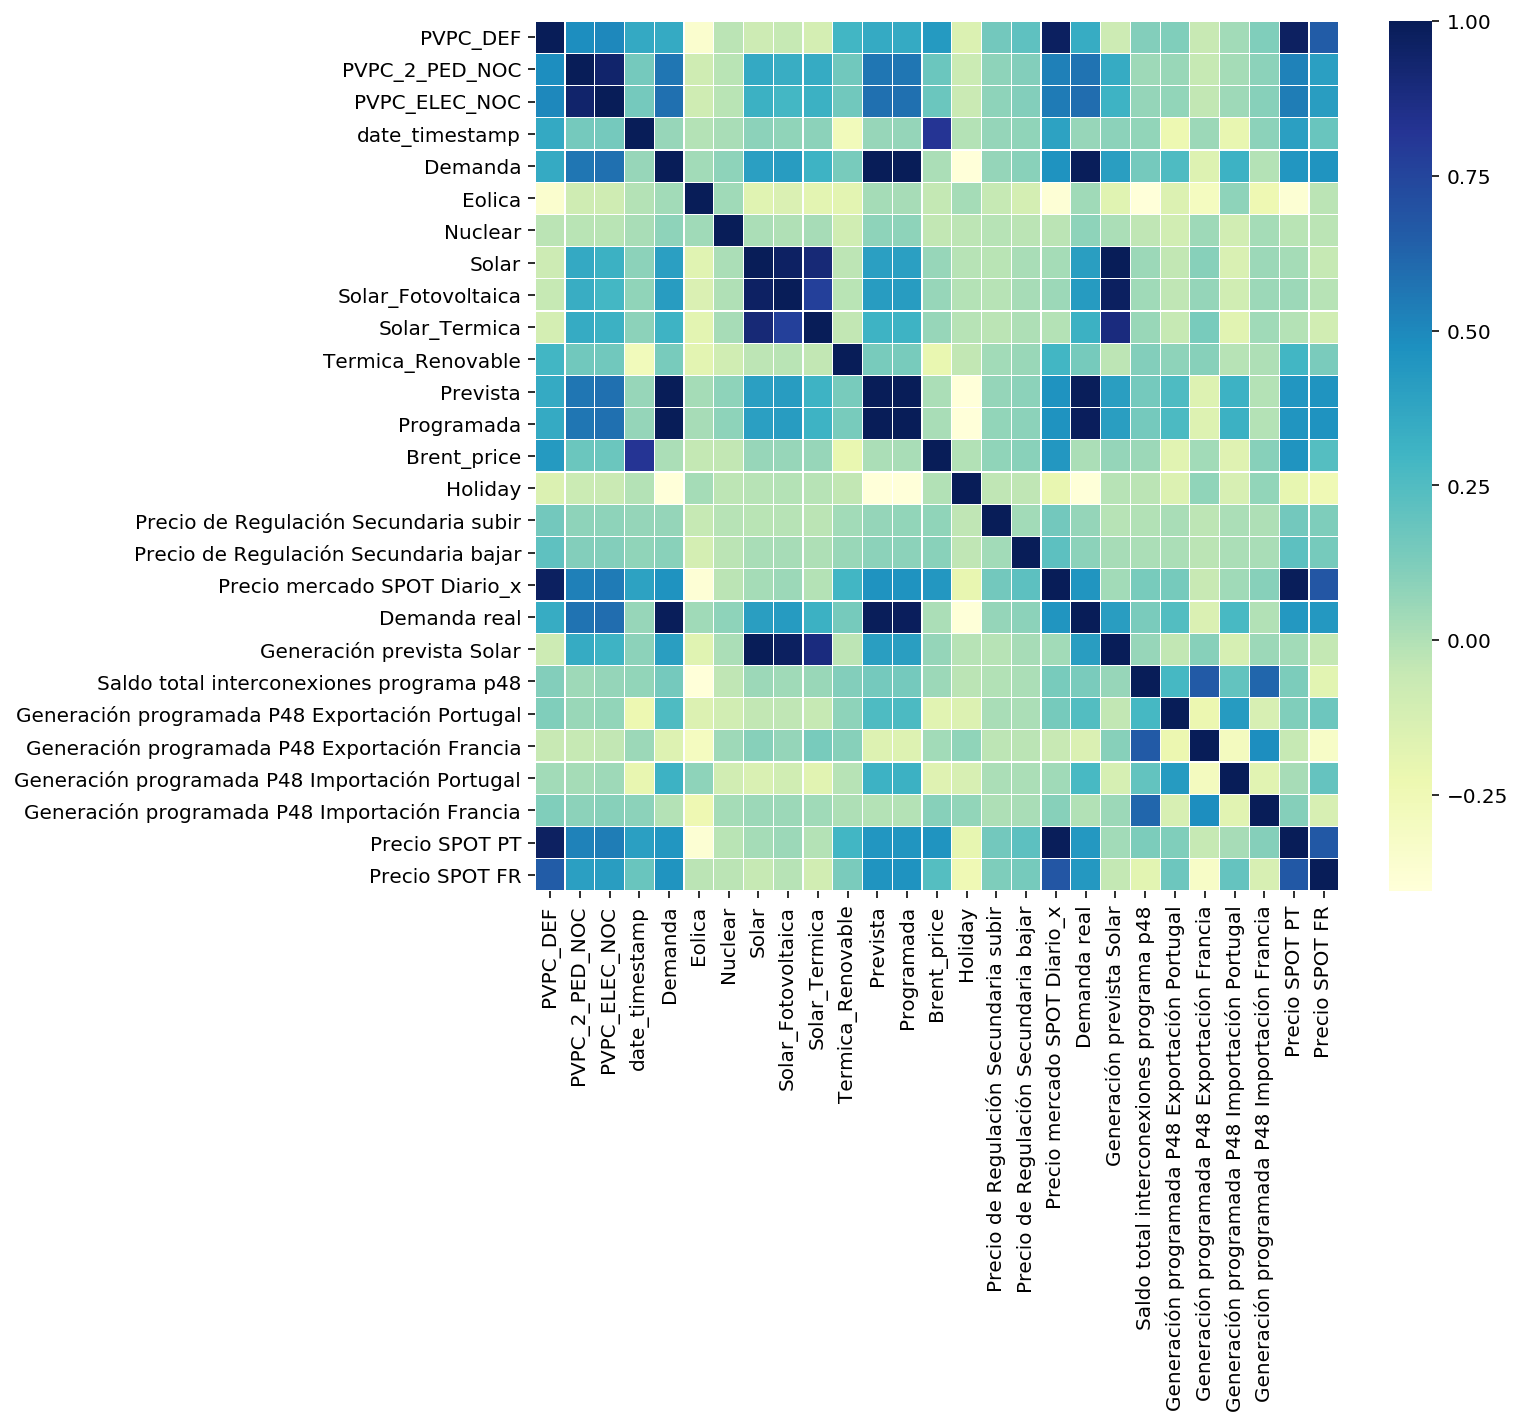

In [131]:
corrmat = data_consumo.corr() 
  
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

Veamos ahora las 13 mejores correlaciones con otras variables  para la varible del **precio**

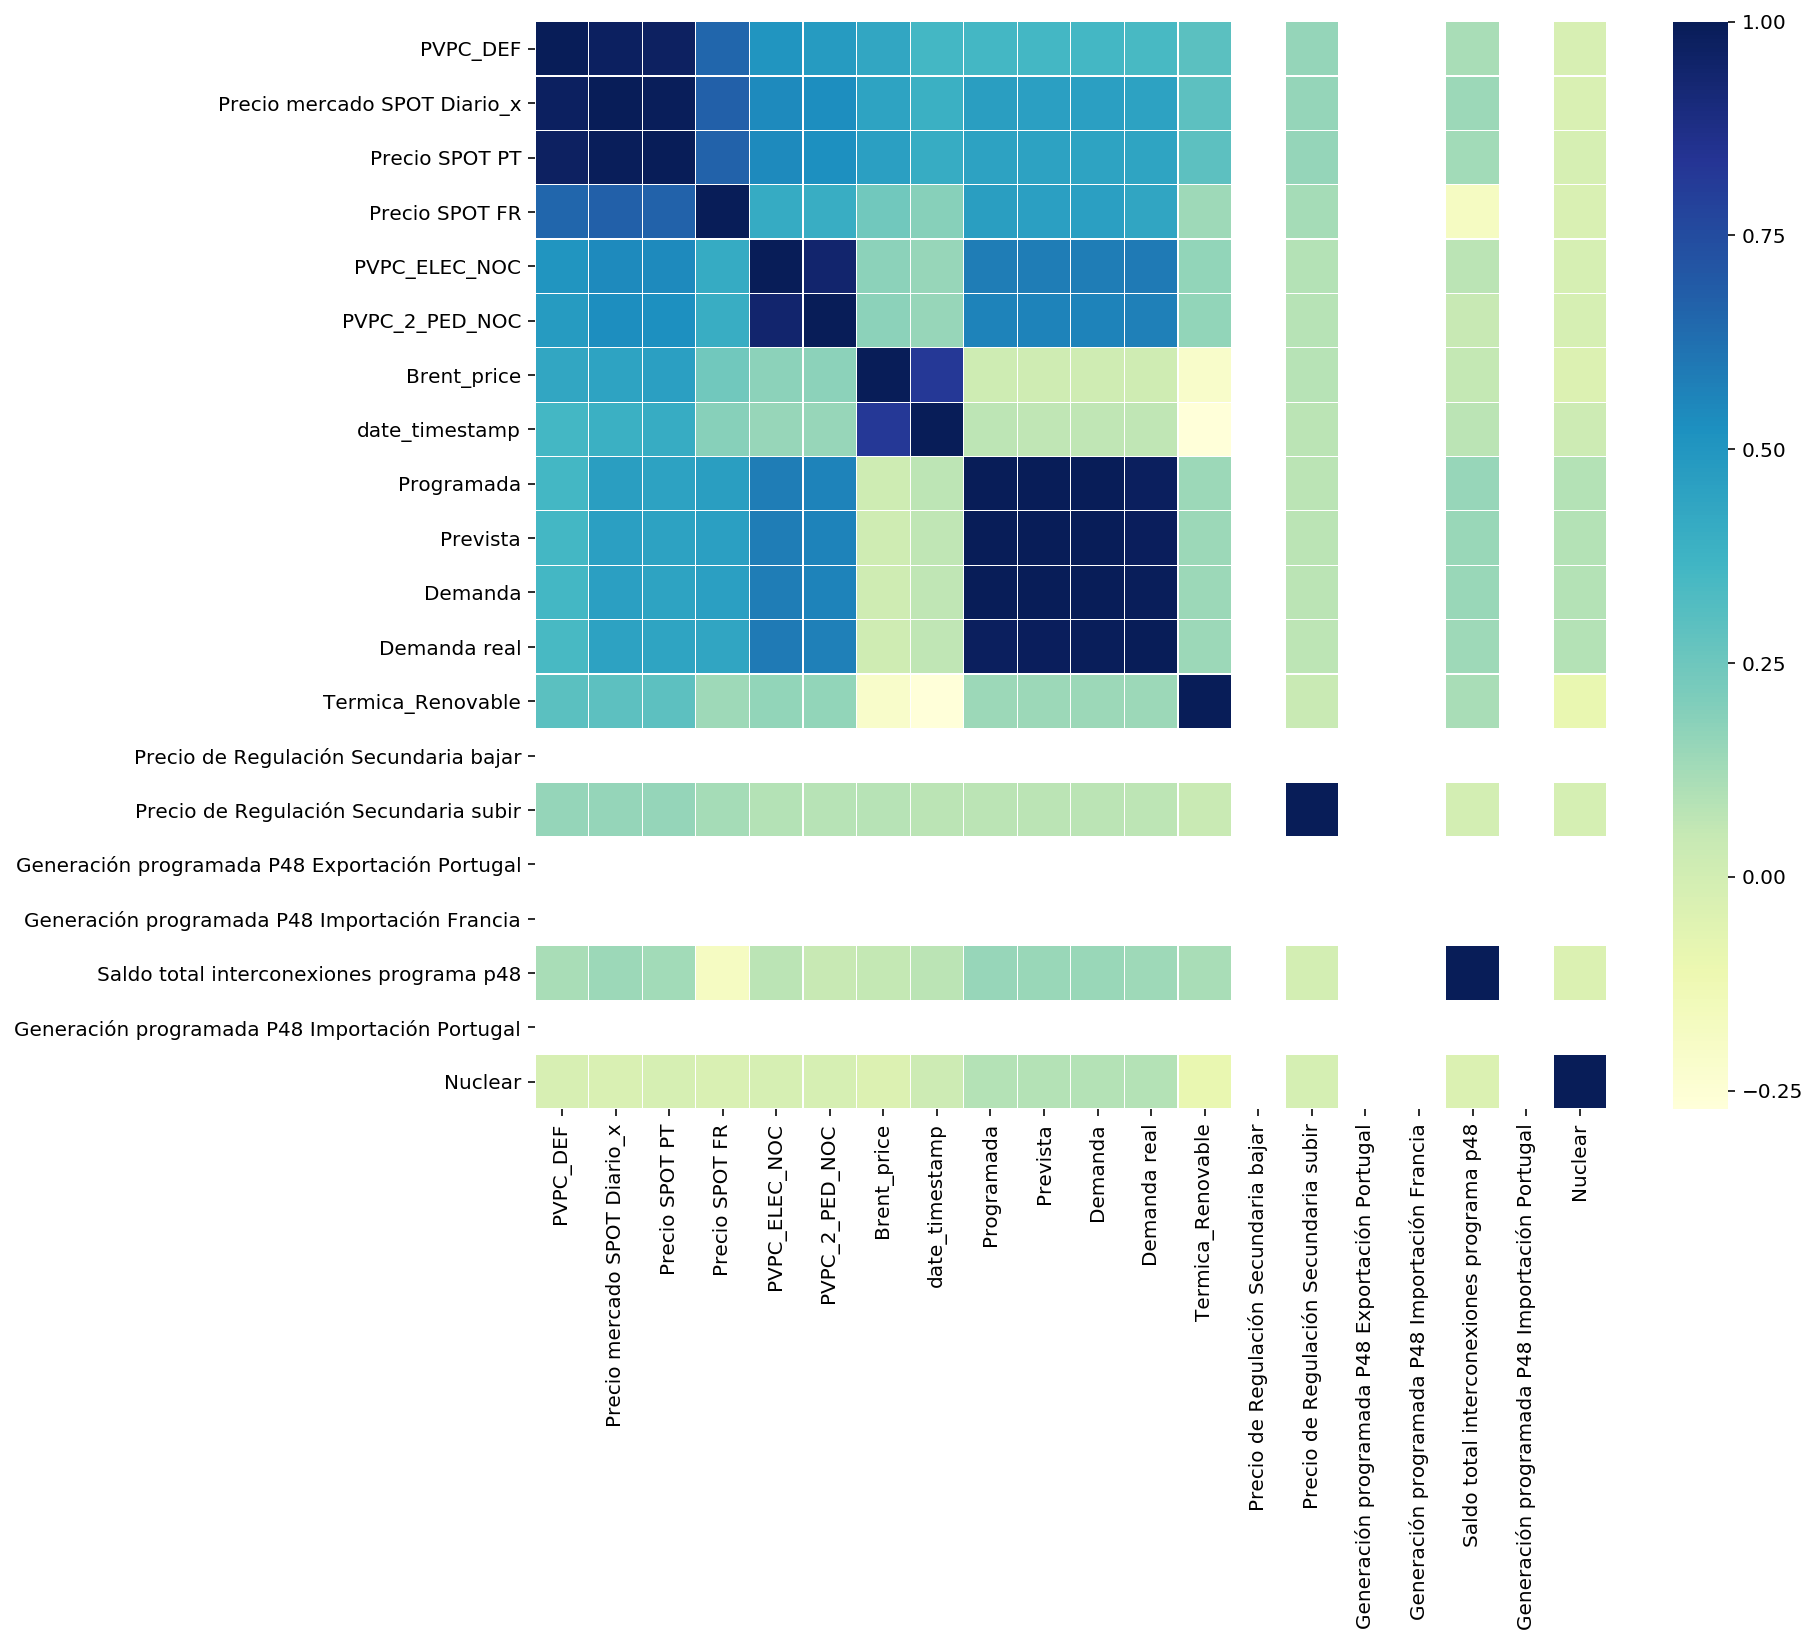

In [132]:
 k = 20
  
cols = corrmat.nlargest(k, 'PVPC_DEF')['PVPC_DEF'].index 
  
cm = np.corrcoef(data_consumo[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 

Bien, obviamente algunas variables como el precio SPOT tiene una alta correlación con el precio, pero estas de la misma forma que el precio pvpc, no la conocemos hasta el D+1. Utilizemos sólo las variables que podemos conocer en tiempo real: 

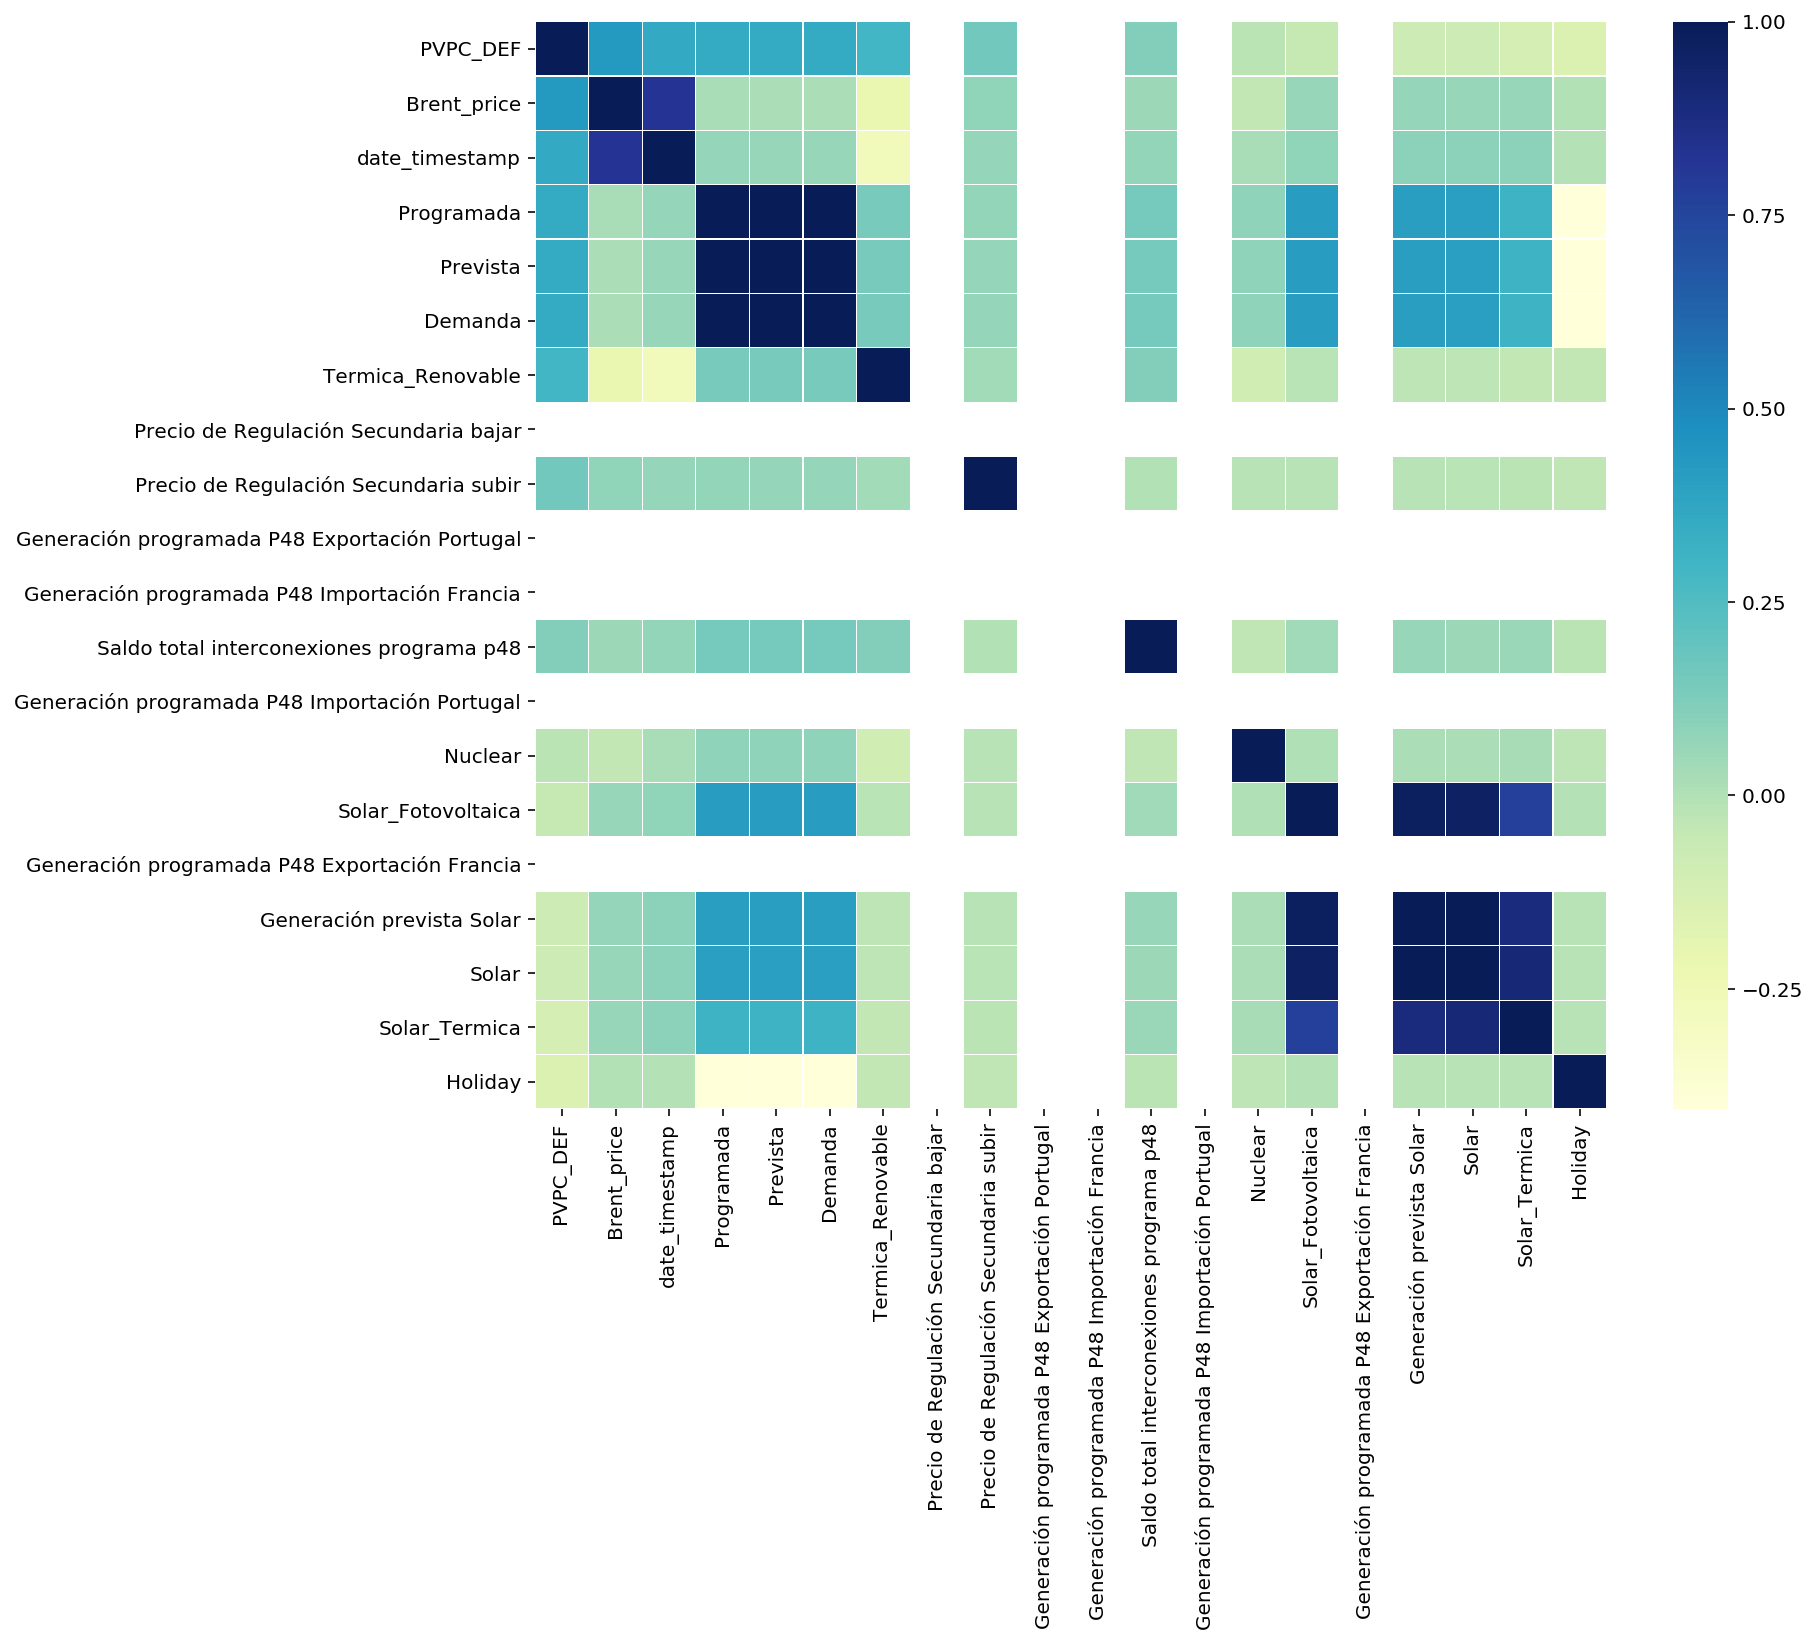

In [142]:
data_consumo_real_time = data_consumo.drop(columns=['PVPC_2_PED_NOC',
                                                    'PVPC_ELEC_NOC',
                                                    'Precio mercado SPOT Diario_x',
                                                    'Precio SPOT PT',
                                                    'Precio SPOT FR',
                                                    'Demanda real',
                                                   ])

k = 20
  
corrmat = data_consumo_real_time.corr()   
cols = corrmat.nlargest(k, 'PVPC_DEF')['PVPC_DEF'].index 
  
cm = np.corrcoef(data_consumo_real_time[cols].values.T) 
f, ax = plt.subplots(figsize =(12, 10)) 
  
sns.heatmap(cm, ax = ax, cmap ="YlGnBu", 
            linewidths = 0.1, yticklabels = cols.values,  
                              xticklabels = cols.values) 

## Visualización de otras variables 

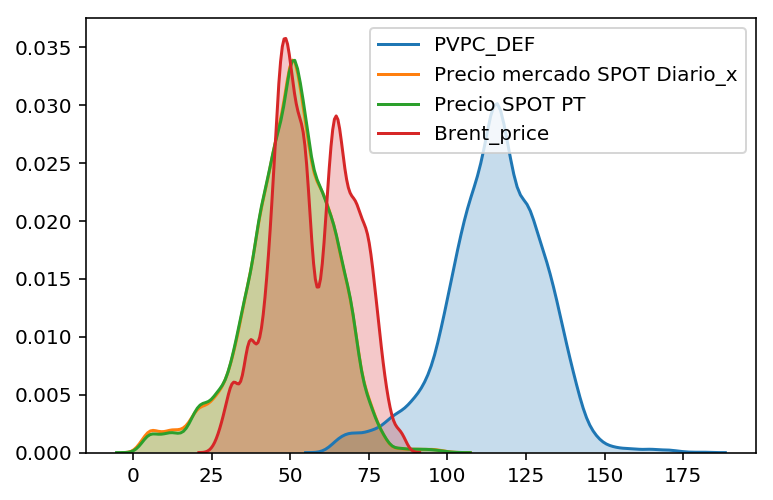

In [133]:
x = data_consumo['date_timestamp']
data_pvpc = data_consumo['PVPC_DEF']

data_spot = data_consumo['Precio mercado SPOT Diario_x']
data_pt = data_consumo['Precio SPOT PT']
data_dem = data_consumo['Demanda']
data_brent = data_consumo['Brent_price']

sns.kdeplot(data_pvpc, shade=True)
sns.kdeplot(data_spot, shade=True)
sns.kdeplot(data_pt, shade=True)
sns.kdeplot(data_brent, shade=True)

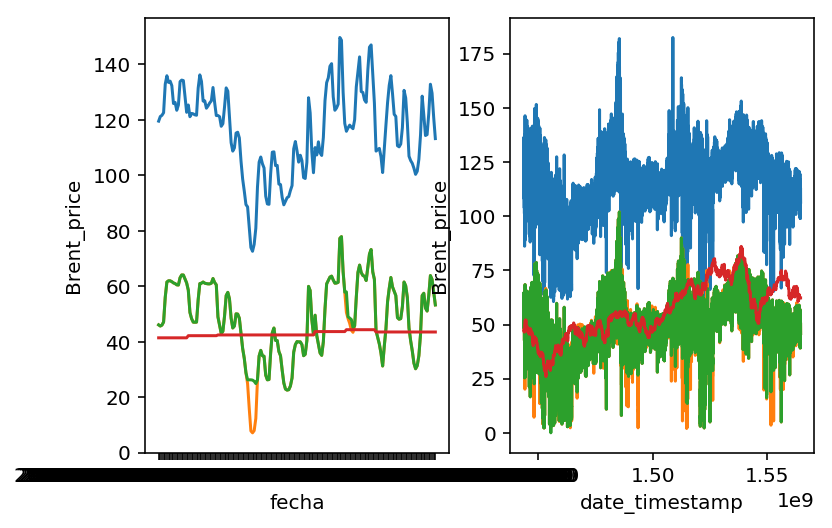

In [156]:
fig, ax =plt.subplots(1,2)
sns.lineplot(data_tiempo_semana, data_pvpc, ax=ax[0])
sns.lineplot(data_tiempo_semana, data_spot, ax=ax[0])
sns.lineplot(data_tiempo_semana, data_pt, ax=ax[0])
sns.lineplot(data_tiempo_semana, data_brent, ax=ax[0])
sns.lineplot(x, data_pvpc, ax=ax[1])
sns.lineplot(x, data_spot, ax=ax[1])
sns.lineplot(x, data_pt, ax=ax[1])
sns.lineplot(x, data_brent, ax=ax[1])
fig.show()

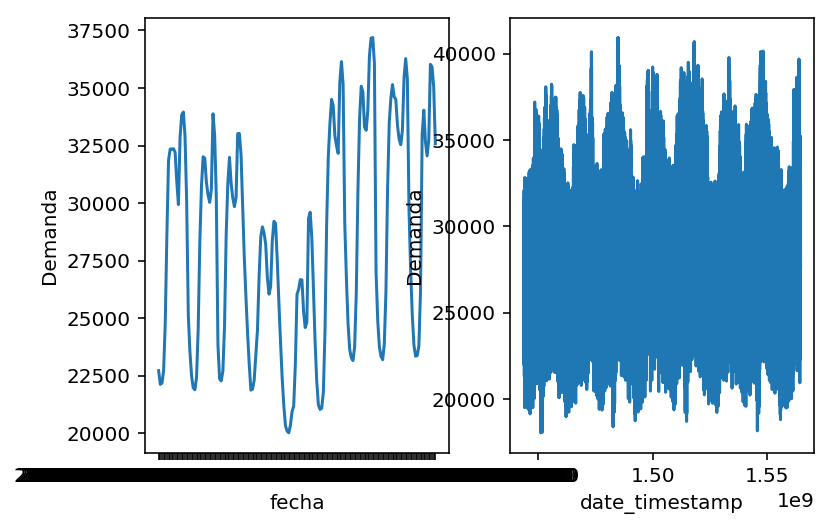

In [151]:

fig, ax =plt.subplots(1,2)
sns.lineplot(data_tiempo_semana, data_dem, ax=ax[0])
sns.lineplot(x, data_dem, ax=ax[1])
fig.show()


Estudio con las variables displobles real-time:

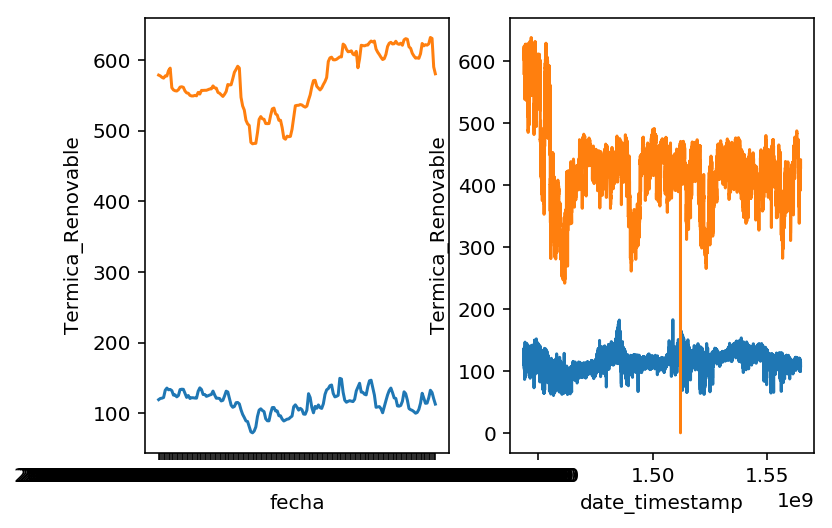

In [150]:
data_termica = data_consumo['Termica_Renovable']
data_prec_sub = data_consumo['Precio de Regulación Secundaria subir']
data_saldo = data_consumo['Saldo total interconexiones programa p48']
data_nuclear = data_consumo['Nuclear']

fig, ax =plt.subplots(1,2)
sns.lineplot(data_tiempo_semana, data_pvpc, ax=ax[0])
sns.lineplot(data_tiempo_semana, data_termica, ax=ax[0])
sns.lineplot(x, data_pvpc,  ax=ax[1])
sns.lineplot(x, data_termica, ax=ax[1])
fig.show()

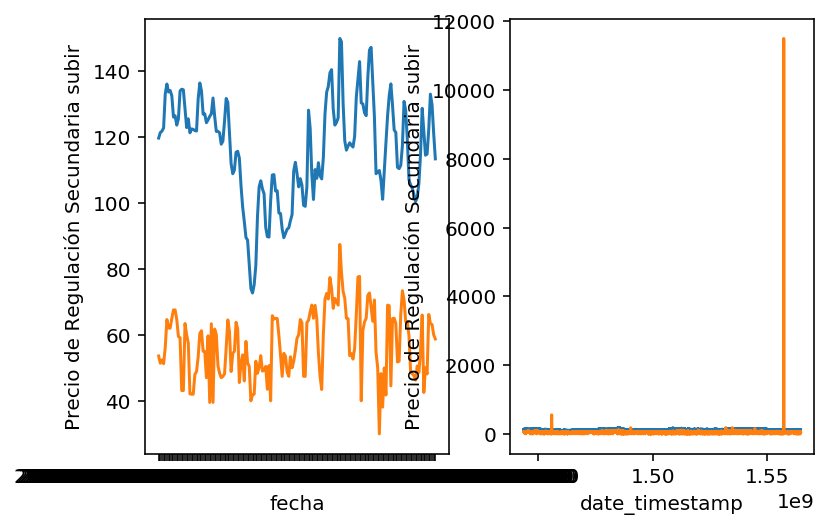

In [153]:

fig, ax =plt.subplots(1,2)
sns.lineplot(data_tiempo_semana, data_pvpc, ax=ax[0])
sns.lineplot(data_tiempo_semana, data_prec_sub, ax=ax[0])
sns.lineplot(x, data_pvpc,  ax=ax[1])
sns.lineplot(x, data_prec_sub, ax=ax[1])
fig.show()

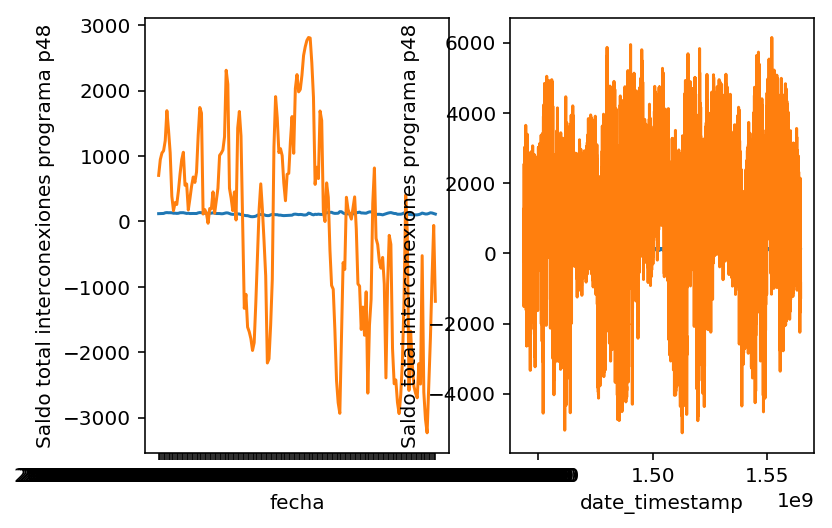

In [154]:

fig, ax =plt.subplots(1,2)
sns.lineplot(data_tiempo_semana, data_pvpc, ax=ax[0])
sns.lineplot(data_tiempo_semana, data_saldo, ax=ax[0])
sns.lineplot(x, data_pvpc,  ax=ax[1])
sns.lineplot(x, data_saldo, ax=ax[1])
fig.show()

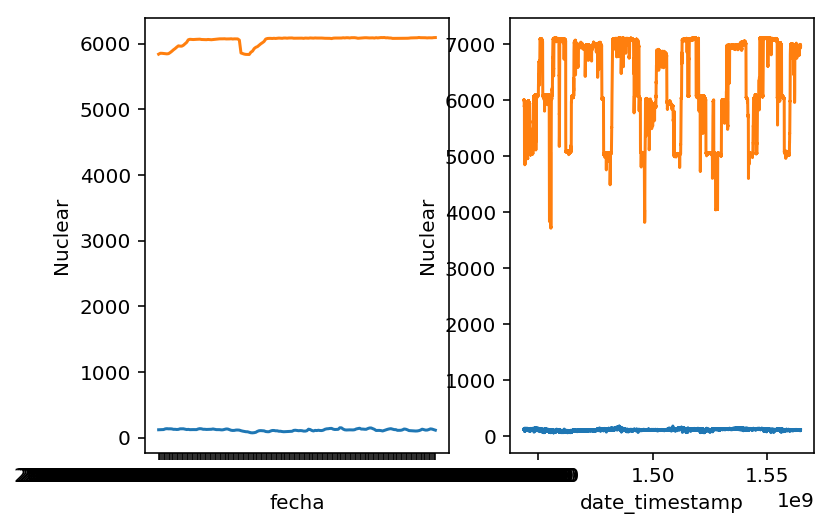

In [155]:

fig, ax =plt.subplots(1,2)
sns.lineplot(data_tiempo_semana, data_pvpc, ax=ax[0])
sns.lineplot(data_tiempo_semana, data_nuclear, ax=ax[0])
sns.lineplot(x, data_pvpc,  ax=ax[1])
sns.lineplot(x, data_nuclear, ax=ax[1])
fig.show()

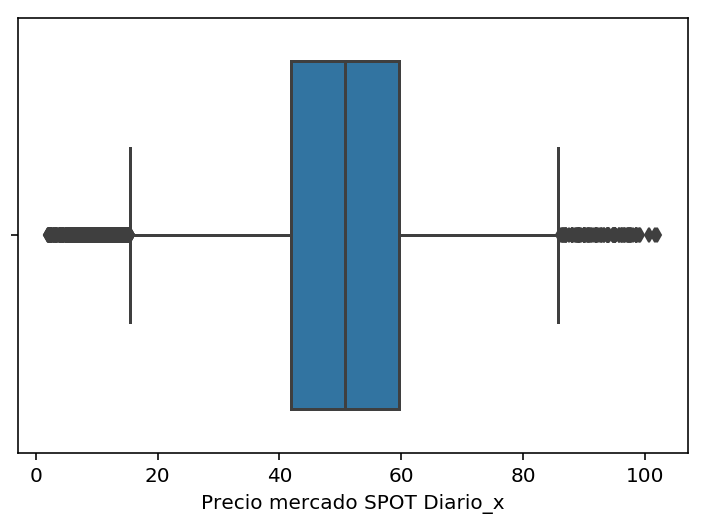

In [136]:
sns.boxplot(data_spot)

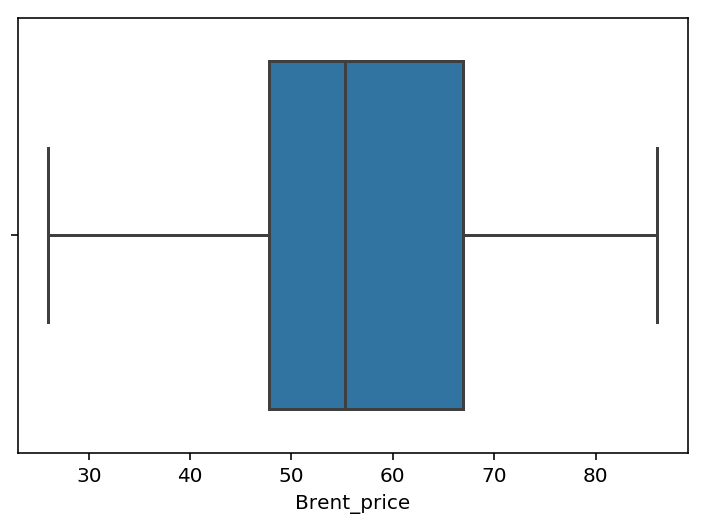

In [137]:
sns.boxplot(data_brent)

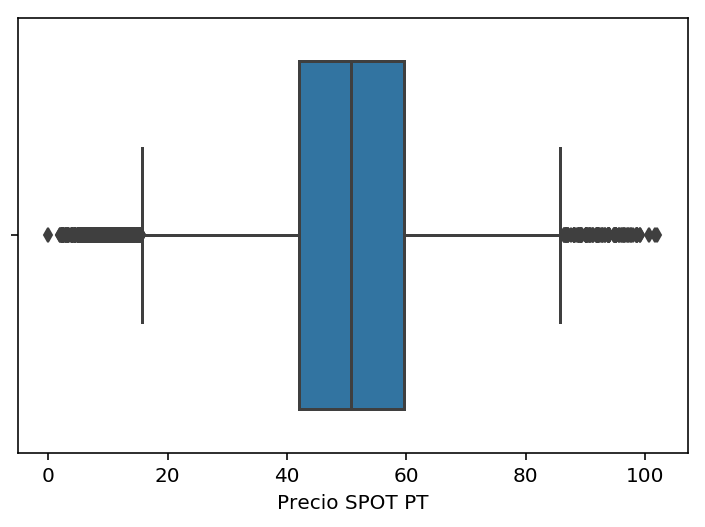

In [138]:
sns.boxplot(data_pt)